In [118]:
import time
import random
import collections
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.special import expit
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from spacy import cli

plt.rcParams["figure.figsize"] = (10,6)

In [119]:
data = pd.read_csv("/Users/gustagol_jr/Desktop/TheCountryMarket/TheCountryMarketAnswers.csv")

In [120]:
data.head(10)

,Timestamp,Which town/municipality do you live in?,How many food retailers are in your town?,How far from your household is the nearest food retailer?,How many times per week does your household do groceries?,At which of the following food retailers have you purchased in the last 3 months?,Does your town of residence have locally-owned grocery store?,What is missing in your current local store experience that you would like to see?,What would help resolve some of the pain points that you mentioned? \nWhat would be the best solution in an ideal world?,"Where do you purchase fresh food such as vegetables, fruits, milk, eggs, etc.?",...,"Due to the small market, products at local grocery store have to be sold in smaller packages compared to Costco or Walmart. How does this impact your decision to shop there?",Is there anything else which you could tell us about your local grocery store?,Did you have a locally-owned grocery store in the past?,Why was this store closed? (you can pick more than 1),How much do you want a grocery store with basic fresh products in your town?,"If your town had a local fresh grocery store, how would it impact your grocery shopping?","If your town had a healthy food alternative to a dollar store, assuming the prices were reasonable, how likely would you shop there?.1","Due to the small market, products at local grocery store have to be sold in smaller packages compared to Costco or Walmart. How does this impact your decision to shop there?.1",How much does your household spend on groceries every month? (on average),What are the top 3 products you consume the most in your household (in a monetary terms)?
0,11/19/2022 16:27:16,"South Bend, Indiana",2,Between 3 miles and 5 miles,3-4 times per week,"Dollar General/Dollar Tree, Walmart, Costco",Yes,knkmknkn,lkkjnkl,NaN,...,NaN,m m,NaN,NaN,NaN,NaN,NaN,NaN,$751-$1000,"Canned food, Alcoholic Beverages, Dry/baking g..."
1,11/22/2022 11:04:33,Town of Milford,1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Walmart, Costco, M...",No,Fresh Produce,"Fresh affordable, quality produce available ye...",NaN,...,NaN,NaN,Yes,I have no idea,5.0,I would be able to have fresh fruits and veget...,5.0,1.0,$501-$750,"Dairy, Frozen foods, Dry/baking goods"
2,11/23/2022 9:23:15,LaPaz,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Martin's, Kroger, ...",Yes,larger variety,LaPaz only has Mac's Market and Dollar General...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$0-$250,"Non-alcoholic beverage, Frozen foods, Meat"
3,11/29/2022 7:33:03,Galien mi,2,Less than 3 miles,1-2 times per week,"Walmart, Meijer",Maybe,Fresh produce,Local delivery from Whole Foods or independent...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Non-alcoholic beverage, Meat, Dry/baking goods"
4,11/29/2022 8:19:11,Bremen,3,Between 5 and 10 miles,1-2 times per week,"Costco, Martin's, Kroger, Local grocery store",Yes,Good fresh produce,"Better suppliers, working with local farmers",NaN,...,NaN,Quality of products has drastically decreased ...,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
5,11/29/2022 8:34:24,"Wakarusa, IN",2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Meijer, Aldi",Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
6,11/29/2022 8:35:24,"Wakarusa, IN",1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Costco, Martin's, ...",No,more fresh/healthy options,trader joes,NaN,...,NaN,NaN,No,No idea,5.0,I would shop there all the time.,5.0,1.0,$1001-$1250,"Bread/bakery, Meat"
7,11/29/2022 8:42:40,"North Liberty, IN",2,Less than 3 miles,1-2 times per week,"Costco, Martin's, Meijer",Yes,"I don't shop at the Dollar General, but the lo...",Not sure what the best solution is because you...,NaN,...,NaN,It's a butcher shop and they have some amazing...,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Dairy, Meat, Dry/baking goods"
8,11/29/2022 8:43:50,Warsaw,5+,Between 3 miles and 5 miles,1-2 t

In [121]:
del data['Timestamp']

In [122]:
data.head(10)

,Which town/municipality do you live in?,How many food retailers are in your town?,How far from your household is the nearest food retailer?,How many times per week does your household do groceries?,At which of the following food retailers have you purchased in the last 3 months?,Does your town of residence have locally-owned grocery store?,What is missing in your current local store experience that you would like to see?,What would help resolve some of the pain points that you mentioned? \nWhat would be the best solution in an ideal world?,"Where do you purchase fresh food such as vegetables, fruits, milk, eggs, etc.?","How far do you travel to purchase fresh food such as vegetables, fruits, milk, eggs, etc.?",...,"Due to the small market, products at local grocery store have to be sold in smaller packages compared to Costco or Walmart. How does this impact your decision to shop there?",Is there anything else which you could tell us about your local grocery store?,Did you have a locally-owned grocery store in the past?,Why was this store closed? (you can pick more than 1),How much do you want a grocery store with basic fresh products in your town?,"If your town had a local fresh grocery store, how would it impact your grocery shopping?","If your town had a healthy food alternative to a dollar store, assuming the prices were reasonable, how likely would you shop there?.1","Due to the small market, products at local grocery store have to be sold in smaller packages compared to Costco or Walmart. How does this impact your decision to shop there?.1",How much does your household spend on groceries every month? (on average),What are the top 3 products you consume the most in your household (in a monetary terms)?
0,"South Bend, Indiana",2,Between 3 miles and 5 miles,3-4 times per week,"Dollar General/Dollar Tree, Walmart, Costco",Yes,knkmknkn,lkkjnkl,NaN,NaN,...,NaN,m m,NaN,NaN,NaN,NaN,NaN,NaN,$751-$1000,"Canned food, Alcoholic Beverages, Dry/baking g..."
1,Town of Milford,1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Walmart, Costco, M...",No,Fresh Produce,"Fresh affordable, quality produce available ye...",NaN,NaN,...,NaN,NaN,Yes,I have no idea,5.0,I would be able to have fresh fruits and veget...,5.0,1.0,$501-$750,"Dairy, Frozen foods, Dry/baking goods"
2,LaPaz,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Martin's, Kroger, ...",Yes,larger variety,LaPaz only has Mac's Market and Dollar General...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$0-$250,"Non-alcoholic beverage, Frozen foods, Meat"
3,Galien mi,2,Less than 3 miles,1-2 times per week,"Walmart, Meijer",Maybe,Fresh produce,Local delivery from Whole Foods or independent...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Non-alcoholic beverage, Meat, Dry/baking goods"
4,Bremen,3,Between 5 and 10 miles,1-2 times per week,"Costco, Martin's, Kroger, Local grocery store",Yes,Good fresh produce,"Better suppliers, working with local farmers",NaN,NaN,...,NaN,Quality of products has drastically decreased ...,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
5,"Wakarusa, IN",2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Meijer, Aldi",Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
6,"Wakarusa, IN",1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Costco, Martin's, ...",No,more fresh/healthy options,trader joes,NaN,NaN,...,NaN,NaN,No,No idea,5.0,I would shop there all the time.,5.0,1.0,$1001-$1250,"Bread/bakery, Meat"
7,"North Liberty, IN",2,Less than 3 miles,1-2 times per week,"Costco, Martin's, Meijer",Yes,"I don't shop at the Dollar General, but the lo...",Not sure what the best solution is because you...,NaN,NaN,...,NaN,It's a butcher shop and they have some amazing...,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Dairy, Meat, Dry/baking goods"
8,Warsaw,5+,Between 3 miles and 5 miles,1-2 times per week,"Walmart, Kroger, Meijer",No,Grocery Store o

In [123]:
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [124]:
data['What is missing in your current local store experience that you would like to see?'].fillna(' ',inplace=True)

In [125]:
model_class, tokenizer_class, pretreined_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretreined_weights)

model = model_class.from_pretrained(pretreined_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [126]:
tokenized = data['What is missing in your current local store experience that you would like to see?'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0             [101, 14161, 22287, 2243, 8950, 2078, 102]
1                                 [101, 4840, 3965, 102]
2                                 [101, 3469, 3528, 102]
3                                 [101, 4840, 3965, 102]
4                           [101, 2204, 4840, 3965, 102]
                             ...                        
137    [101, 4840, 3965, 1010, 2204, 6240, 2533, 1010...
138    [101, 2632, 4305, 2030, 16269, 2544, 1997, 130...
139      [101, 15184, 1998, 2152, 3737, 4840, 3965, 102]
140                                     [101, 2498, 102]
141            [101, 3029, 1013, 3688, 2006, 15475, 102]
Name: What is missing in your current local store experience that you would like to see?, Length: 142, dtype: object

In [127]:
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i+[0]*(max_len-len(i)) for i in tokenized.values])

padded = np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(142, 66)

In [128]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(142, 66)

In [129]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask = attention_mask)

In [130]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(142, 768)

In [131]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

features_2D = TSNE(n_components=2).fit_transform(features)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters,random_state=42)
clusters = kmeans.fit_predict(features_2D)


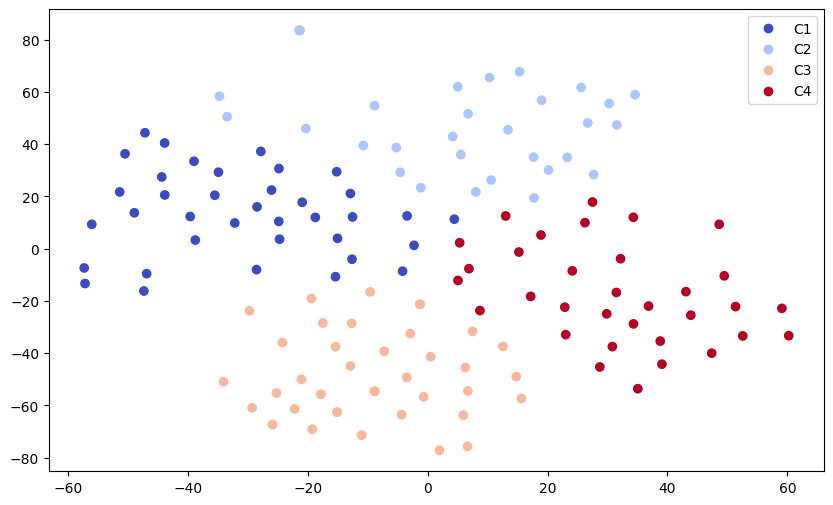

In [132]:
scatter = plt.scatter(features_2D[:,0],features_2D[:,1],c=clusters,cmap='coolwarm')
plt.legend(handles=scatter.legend_elements()[0], labels=[f"C{i}" for i in range(1,n_clusters+1)])

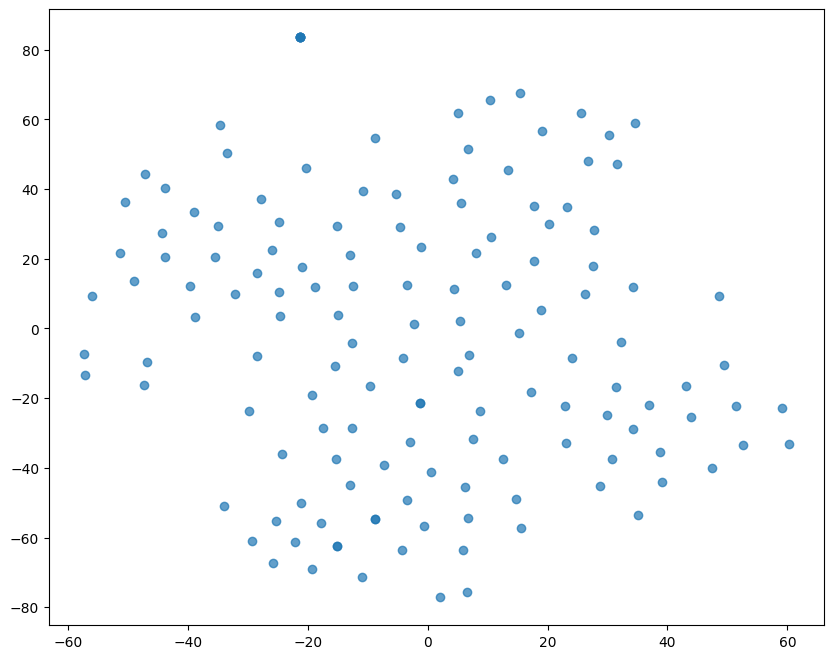

In [133]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(features_2D[:, 0], features_2D[:, 1], alpha=.7)

In [134]:
import umap

umap_embeddings = umap.UMAP(n_neighbors=10,n_components=5,metric = 'cosine').fit_transform(features)

In [135]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [136]:
cluster.labels_

array([ 2,  2,  2, -1,  2, -1,  2,  0,  2,  2,  0, -1, -1,  0,  2,  2,  2,
        2,  2,  2,  2,  2, -1,  2,  0, -1,  2,  2, -1,  2, -1,  2,  2,  0,
        2,  0, -1,  2,  0,  2, -1,  1,  0,  0, -1,  0,  2,  0,  2,  2,  2,
        2,  0,  2, -1,  2, -1,  2, -1,  2,  2,  2,  2,  2,  2,  0,  1, -1,
        1,  1,  2, -1, -1, -1,  1, -1,  2,  2,  0,  1,  2,  1,  2,  2,  2,
        2, -1,  2,  0, -1,  1, -1,  2,  2,  1,  1,  2, -1, -1,  2,  1, -1,
        2,  1,  2, -1,  2,  2,  2, -1, -1,  2,  2,  2,  2,  2,  0,  0,  2,
        1, -1, -1,  2,  0,  0,  2,  2, -1, -1,  2,  2,  2,  2,  2,  2,  2,
        0,  2,  2, -1,  1,  2])

In [137]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(features)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



In [138]:
values0 = result.loc[result['labels'] == 0].index.tolist()

In [139]:
values1 = result.loc[result['labels'] == 1].index.tolist()

In [140]:
g = data.drop(values0)

In [141]:
featgroup0 = features[values1, :]

In [142]:
umap_embeddings = umap.UMAP(n_neighbors=10,n_components=5,metric = 'cosine').fit_transform(featgroup0)
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [143]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(featgroup0)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_


In [144]:
cluster.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

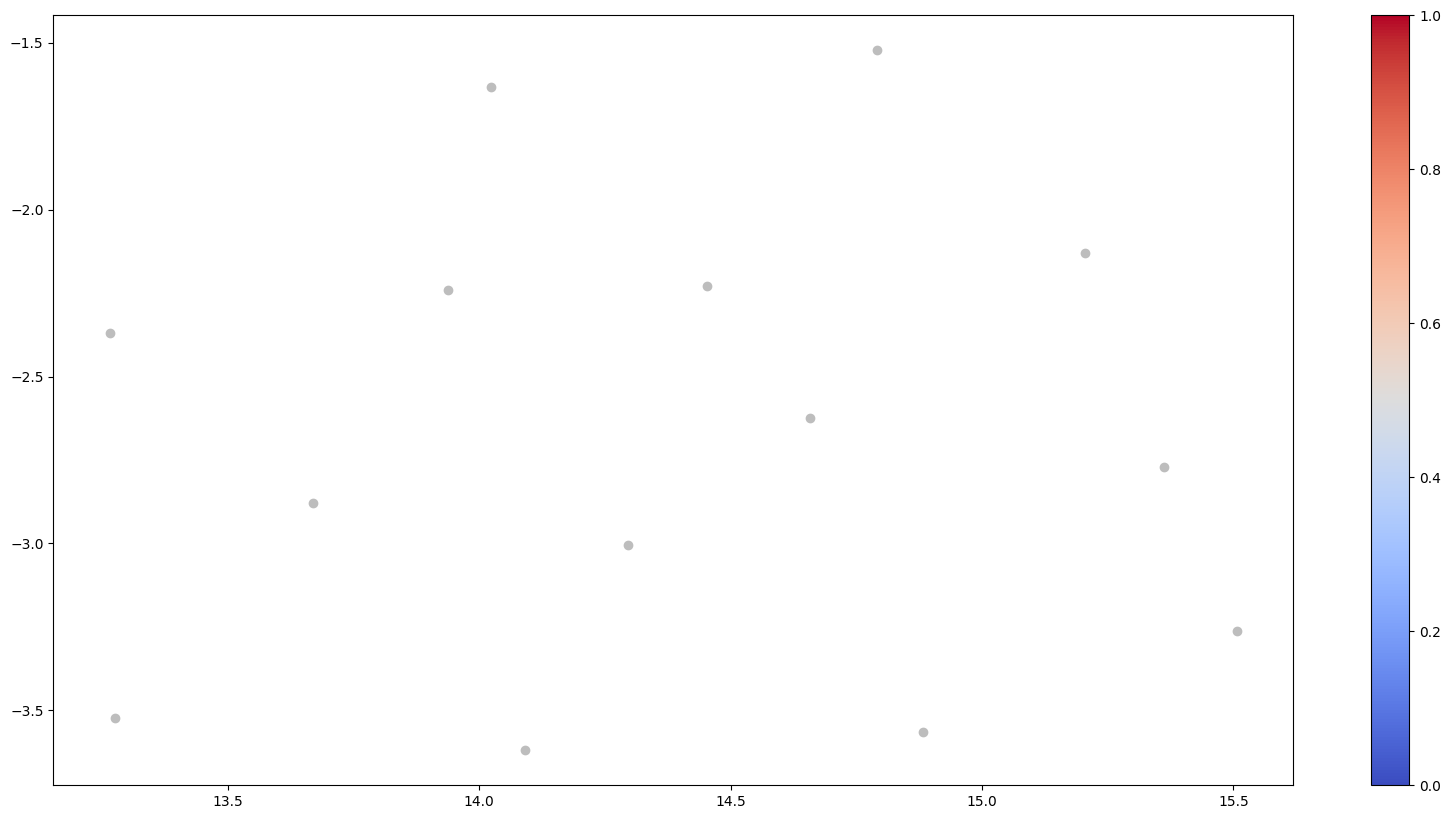

In [145]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='coolwarm',s=50)
plt.colorbar()

In [146]:
values0 = result.loc[result['labels'] == 0].index.tolist()

In [147]:
values0

[]

In [148]:
g.iloc[values0]['What would help resolve some of the pain points that you mentioned? \nWhat would be the best solution in an ideal world?']

Series([], Name: What would help resolve some of the pain points that you mentioned? \nWhat would be the best solution in an ideal world?, dtype: object)

## Topic Modeling - Applying labels to each sentence

In [149]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components = n_components,
                                 metric='cosine',
                                 random_state=random_state).fit_transform(message_embeddings))
    
    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [150]:
def score_clusters(clusters, prob_threshold = 0.05):
    
    clusters_labels = clusters.labels_
    label_count = len(np.unique(clusters_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [151]:
def random_search(embeddings,space,num_evals):
    
    results = []
    
    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [152]:
space = {"n_neighbors" : range(12,16),
         "n_components": range(3,7),
         "min_cluster_size": range(2,16),
         "random_state": 42}

random_use = random_search(features, space, 100)

In [153]:
random_use.head(25)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
48,48,13,4,6,2,0.000000
28,28,12,3,5,2,0.000000
15,15,12,3,10,3,0.035211
35,35,15,5,9,3,0.042254
69,69,13,4,10,3,0.042254
86,86,12,3,13,3,0.042254
44,44,13,4,14,3,0.042254
7,7,13,4,9,3,0.042254
70,70,15,5,10,3,0.042254
10,10,13,4,9,3,0.042254


In [154]:
from hyperopt import Trials, STATUS_OK, space_eval, fmin, tpe, hp

In [155]:
def objective(params, embeddings, label_lower, label_upper):
     
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [156]:

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [157]:
hspace = { "n_neighbors": hp.choice('n_neighbors', range(3,16)),
           "n_components": hp.choice('n_components',range(3,16)),
           "min_cluster_size": hp.choice('min_cluster_size',range(2,16)),
           "random_state":42}

label_lower = 3
label_upper = 5
max_evals = 100

In [158]:
best_params, best_clusters_use, trials_use = bayesian_search(features,
                                                             space=hspace,
                                                             label_lower=label_lower,
                                                             label_upper=label_upper,
                                                             max_evals=max_evals)

100%|██████████| 100/100 [01:10<00:00,  1.41trial/s, best loss: 0.0]              
best:
{'min_cluster_size': 3, 'n_components': 4, 'n_neighbors': 5, 'random_state': 42}
label count: 3


In [159]:
def plot_best_clusters(best_clusters_use,embeddings,n_neighbors=15,min_dist=0.1):
    
        umap_reduce = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components=2,
                                 min_dist=min_dist,
                                 metric='cosine',
                                 random_state=42)
                           .fit_transform(embeddings)
                       )

        point_size = 100.0 / np.sqrt(embeddings.shape[0])

        result = pd.DataFrame(umap_reduce, columns=['x', 'y'])
        result['labels'] = best_clusters_use.labels_

        fig, ax = plt.subplots(figsize=(14, 8))
        noise = result[result.labels == -1]
        clustered = result[result.labels != -1]
        plt.scatter(noise.x, noise.y, color='lightgrey', s=point_size)
        plt.scatter(clustered.x, clustered.y, c=clustered.labels,
                    s=point_size, cmap='jet')
        plt.colorbar()
        plt.show()

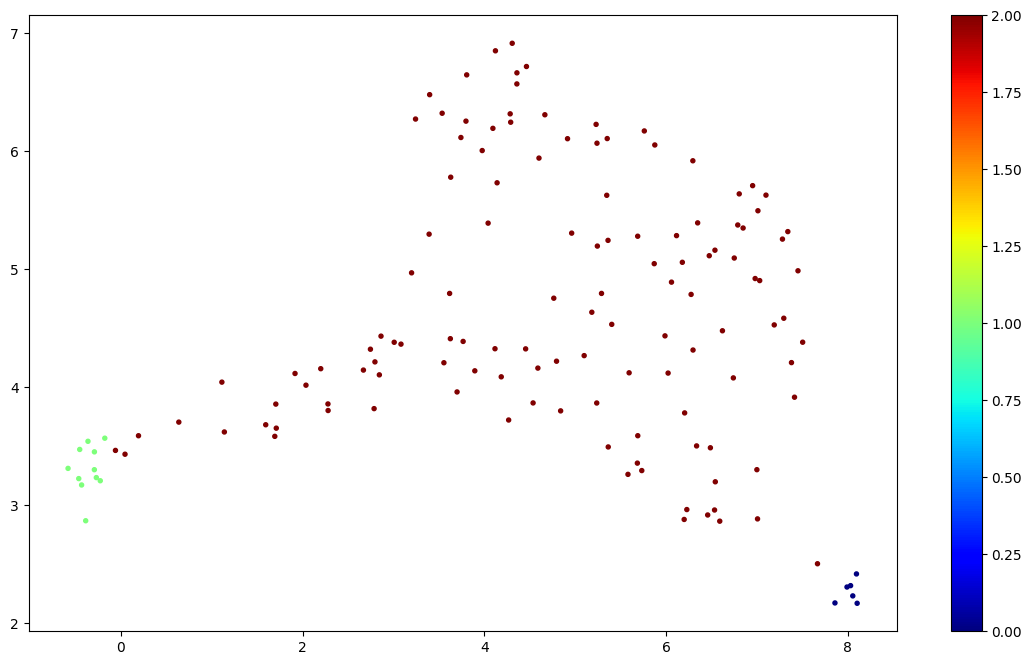

In [160]:
plot_best_clusters(best_clusters_use,features)

In [161]:
def get_group(df, category_col, category):
        """
        Return single category of documents with known labels
        Arguments:
            df: pandas dataframe of documents and associated ground truth
                labels
            category_col: str, name of column with document labels
            category: str, single document label of interest
        Returns:
            single_category: pandas dataframe with only documents from a
                             single category of interest
        """

        single_category = (df[df[category_col] == category]
                           .reset_index(drop=True)
                           )

        return single_category

In [162]:
def most_common(lst, n_words):
        """
        Return most common n words in list of words
        Arguments:
            lst: list of words
            n_words: int, number of top words by frequency to return
        Returns:
            counter.most_common(n_words): a list of the n most common elements
                                          and their counts from the most
                                          common to the least
        """

        counter = collections.Counter(lst)

        return counter.most_common(n_words)



In [163]:
import spacy
def extract_labels( category_docs):
        """
        Extract labels from documents in the same cluster by concatenating
        most common verbs, ojects, and nouns
        Argument:
            category_docs: list of documents, all from the same category or
                        clustering
        Returns:
            label: str, group label derived from concatentating most common
                   verb, object, and two most common nouns
        """

        verbs = []
        dobjs = []
        nouns = []
        adjs = []

        verb = ''
        dobj = ''
        noun1 = ''
        noun2 = ''

        try:
            nlp = spacy.load("en_core_web_sm")
        except OSError:
            print("Downloading language model for the spaCy dependency parser\n"
                  "(only required the first time this is run)\n")
            
            cli.download("en_core_web_sm")
            nlp = spacy.load("en_core_web_sm")

        for i in range(len(category_docs)):
            doc = nlp(category_docs[i])
            for token in doc:
                if token.is_stop is False:
                    if token.dep_ == 'ROOT':
                        verbs.append(token.text.lower())

                    elif token.dep_ == 'dobj':
                        dobjs.append(token.lemma_.lower())

                    elif token.pos_ == 'NOUN':
                        nouns.append(token.lemma_.lower())

                    elif token.pos_ == 'ADJ':
                        adjs.append(token.lemma_.lower())

        if len(verbs) > 0:
            verb = most_common(verbs, 1)[0][0]

        if len(dobjs) > 0:
            dobj = most_common(dobjs, 1)[0][0]

        if len(nouns) > 0:
            noun1 = most_common(nouns, 1)[0][0]

        if len(set(nouns)) > 1:
            noun2 = most_common(nouns, 2)[1][0]

        words = [verb, dobj]

        # ensures duplicated words aren't included
        for word in [noun1, noun2]:
            if word not in words:
                words.append(word)

        if '' in words:
            words.remove('')

        label = '_'.join(words)

        return label

In [164]:
def apply_and_summarize_labels(best_clusters_use, df_data,category):
        """
        Assign groups to original documents and provide group counts
        Arguments:
            df_data: pandas dataframe of original documents of interest to
                     cluster
        Returns:
            df_summary: pandas dataframe with model cluster assignment, number
                        of documents in each cluster and derived labels
            labeled_docs: pandas dataframe with model cluster assignment and
                          associated dervied label applied to each document in
                          original corpus
        """

        # create a dataframe with cluster numbers applied to each doc
        category_col = 'label_use'
        df_clustered = df_data.copy()
        df_clustered[category_col] =  best_clusters_use.labels_

        numerical_labels = df_clustered[category_col].unique()

        label_dict = {}
        
        for label in numerical_labels:
            current_category = list(get_group(df_clustered,category_col,label)['What is missing in your current local store experience that you would like to see?'])
            print(extract_labels(current_category))
        
        df_summary = (df_clustered.groupby(category_col)['What is missing in your current local store experience that you would like to see?'].count()
                      .reset_index()
                      .rename(columns={'What is missing in your current local store experience that you would like to see?': 'count'})
                      .sort_values('count', ascending=False))
        
        df_summary['label'] = df_summary.apply(lambda x:
                                        label_dict[x[category_col]],
                                        axis=1)
        labeled_docs = pd.merge(df_clustered,
                        df_summary[[category_col, 'label']],
                        on=category_col,
                        how='left')

        return df_summary, labeled_docs
        